[0: NumPy and the ndarray](gridded_data_tutorial_0.ipynb) | [1: Introduction to xarray](gridded_data_tutorial_1.ipynb)  | [2: Daymet data access](gridded_data_tutorial_2.ipynb) | **3: Investigating SWE at Mt. Rainier with Daymet**

# Notebook 3: Investigating SWE at Mt. Rainier with Daymet
Waterhackweek 2020 | Steven Pestana (spestana@uw.edu)

**By the end of this notebook you will be able to:**
* Plot gridded datasets
* Compute summary statistics on gridded data
* Aggregate gridded datasets spatially and temporally

---

**A research question:**
### How has April 1st SWE around Mt. Rainier changed over the past 40 years?

In [1]:
import xarray as xr

# for working with geospatial data
import geopandas as gpd
from pyproj import CRS
from shapely import geometry

# for plotting, import matplotlib.pyplot
import matplotlib.pyplot as plt
# tell jupyter to display plots "inline" in the notebook
%matplotlib inline

---
**Access DayMet data through OPeNDAP with xarray**

And as in the previous notebook, we'll select a smaller area, this time just around Mt. Rainier in Washington.

In [2]:
# Open DayMet Dataset
ds = xr.open_dataset("https://thredds.daac.ornl.gov/thredds-daymet/dodsC/daymet-v3-agg/na.ncml")

# Get the coordinate reference system used by DayMet
daymet_crs = CRS.from_cf(ds.lambert_conformal_conic.attrs)

Make our Mt. Rainier bounding box and use it to subset the DayMet dataset:

In [3]:
# Specify the region we want to look at with DayMet (lon_min, lat_min, lon_max, lat_max)
# and the coordinate system we are providing the bounding box coordinates in (epsg:4326)
# finally, reproject our bounding box polygon into this new coordinate system (Lambert Conformal Conic)
bounding_box = gpd.GeoSeries(geometry.box(-122.0, 46.6, -121.5, 47.1), crs='epsg:4326').to_crs(daymet_crs)

# Select this region from our DayMet Dataset
rainier = ds.sel(x = slice(bounding_box.bounds.minx[0], bounding_box.bounds.maxx[0]),
                 y = slice(bounding_box.bounds.maxy[0], bounding_box.bounds.miny[0]))

In [4]:
# Look at what we selected from DayMet
rainier

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 14600, x: 48, y: 60)
Coordinates:
  * x                        (x) float32 -1590250.0 -1589250.0 ... -1543250.0
  * y                        (y) float32 696000.0 695000.0 ... 638000.0 637000.0
  * time                     (time) datetime64[ns] 1980-01-01 ... 2019-12-31
    lat                      (y, x) float32 ...
    lon                      (y, x) float32 ...
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 ...
    yearday                  (time) int16 ...
    time_bnds                (time, nv) datetime64[ns] ...
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

**Plot SWE for the first day** to make sure we're looking at Mt. Rainier

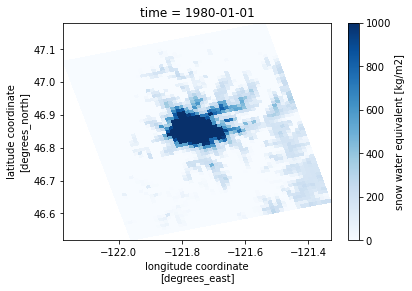

In [5]:
rainier.isel(time=0).swe.plot(x='lon', y='lat', cmap='Blues')

---

**We want to look at values only for April 1st SWE.** We can do this with a combination of boolean (True/False) arrays and the `.sel()` method.

In [6]:
# An expression like this will produce a boolean DataArray, only True where the month is = 4 (April)

rainier['time.month'] == 4

<xarray.DataArray 'month' (time: 14600)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31

In [7]:
# We can combine these expressions with operators like & (and)

(rainier['time.month'] == 4) & (rainier['time.day'] == 1)

<xarray.DataArray (time: 14600)>
array([False, False, False, ..., False, False, False])
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01 1980-01-02 ... 2019-12-31

In [8]:
# And finally used them with an expression within .sel() to get values that only correspond with "True"
rainier_april1 = rainier.sel(time=( (rainier['time.month'] == 4) & (rainier['time.day'] == 1) ) )

**See what we've selected now**

In [9]:
# We end up with 40 points in time, one day for each year
rainier_april1

<xarray.Dataset>
Dimensions:                  (nv: 2, time: 40, x: 48, y: 60)
Coordinates:
  * x                        (x) float32 -1590250.0 -1589250.0 ... -1543250.0
  * y                        (y) float32 696000.0 695000.0 ... 638000.0 637000.0
  * time                     (time) datetime64[ns] 1980-04-01 ... 2019-04-01
    lat                      (y, x) float32 47.06006 47.06253 ... 46.63735
    lon                      (y, x) float32 -122.16852 -122.15523 ... -121.33641
Dimensions without coordinates: nv
Data variables:
    lambert_conformal_conic  int16 -32767
    yearday                  (time) int16 91 90 90 90 91 90 ... 90 91 90 90 90
    time_bnds                (time, nv) datetime64[ns] 1980-04-01 ... 2019-04-02
    dayl                     (time, y, x) float32 ...
    prcp                     (time, y, x) float32 ...
    srad                     (time, y, x) float32 ...
    swe                      (time, y, x) float32 ...
    tmax                     (time, y, x) float32 ...
    tmin                     (time, y, x) float32 ...
    vp                       (time, y, x) float32 ...
Attributes:
    start_year:        1980
    source:            Daymet Software Version 3.0
    Version_software:  Daymet Software Version 3.0
    Version_data:      Daymet Data Version 3.0
    Conventions:       CF-1.6
    citation:          Please see http://daymet.ornl.gov/ for current Daymet ...
    references:        Please see http://daymet.ornl.gov/ for current informa...
    title:             Daymet: Daily Surface Weather Data on a 1-km Grid for ...
    institution:       Oak Ridge National Laboratory Distributed Active Archi...
    end_year:          2019

**Plot Aptil 1 SWE for each year over the 40 year record.** xarray gives us some handy plotting tools for something like this.

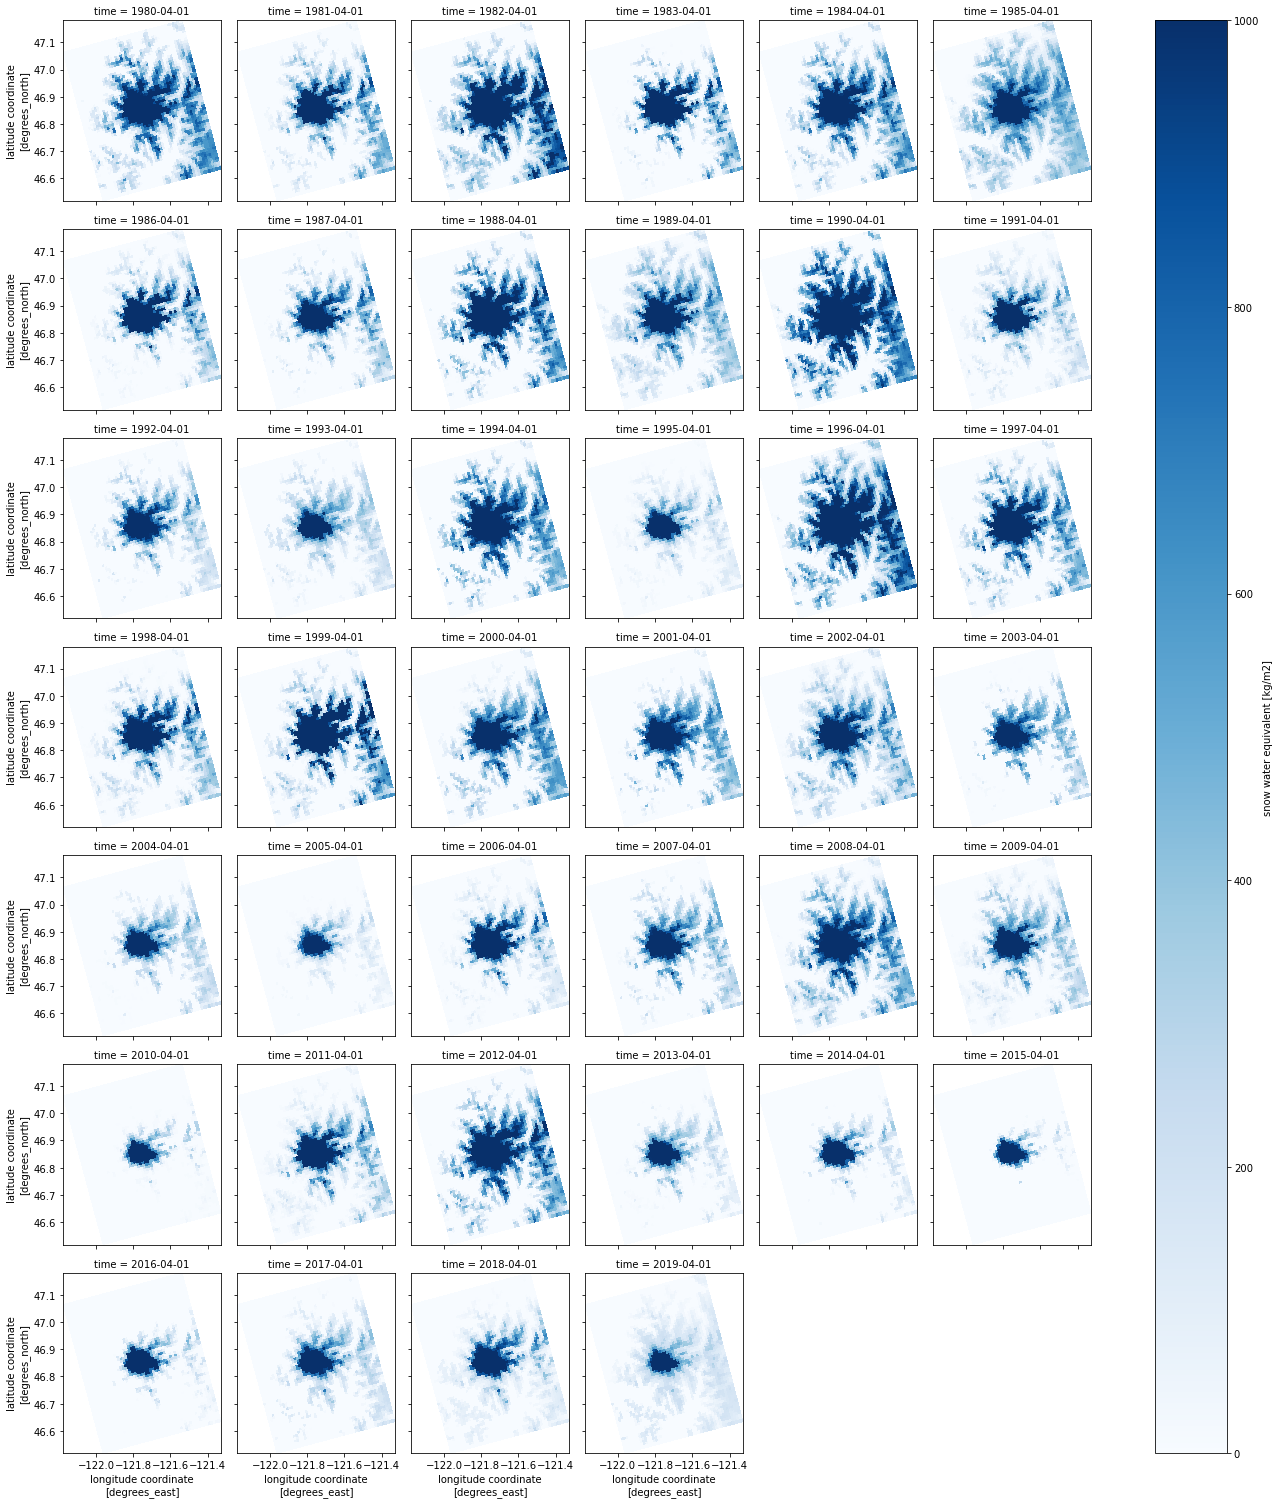

In [10]:
# In this plot statement, we use col='time' to tell xarray that we want an individual plot for each time value
# and col_wrap=6 to tell xarray to plot 6 of these in a row, then wrap around and keep plotting...
rainier_april1.swe.plot(x='lon', y='lat', col='time', col_wrap=6, cmap='Blues')

**Compute summary statistics for the whole dataset:**



In [11]:
# This gives us the mean SWE value in the entire DataArray (across space and time)
rainier_april1.swe.mean()

#rainier_april1.swe.std() # standard deviation
#rainier_april1.swe.min() # minimum
#rainier_april1.swe.max() # maximum

<xarray.DataArray 'swe' ()>
array(173.7797, dtype=float32)

**Compute the mean across time only:**

(this maintains our spatial dimensions)

In [12]:
# But we can be more precise, and get a mean across time only, maintaining our spatial dimensions
rainier_april1.swe.mean('time')

<xarray.DataArray 'swe' (y: 60, x: 48)>
array([[  0. ,   0. ,   0. , ...,  34.4,  18.3,   5.9],
       [  0. ,   0. ,   0. , ..., 111.6,  24.7,  20.9],
       [  0. ,   0. ,   0. , ..., 128.5,  64.8,  81.2],
       ...,
       [  0. ,   0. ,   0. , ..., 144.6, 113.7,  66.8],
       [  0. ,   0. ,   0. , ..., 177.4, 130.5,  79.9],
       [  0. ,   0. ,   0. , ..., 284.2, 359.2, 344.4]], dtype=float32)
Coordinates:
  * x        (x) float32 -1590250.0 -1589250.0 ... -1544250.0 -1543250.0
  * y        (y) float32 696000.0 695000.0 694000.0 ... 638000.0 637000.0
    lat      (y, x) float32 47.06006 47.06253 47.065 ... 46.634964 46.63735
    lon      (y, x) float32 -122.16852 -122.15523 ... -121.34964 -121.33641

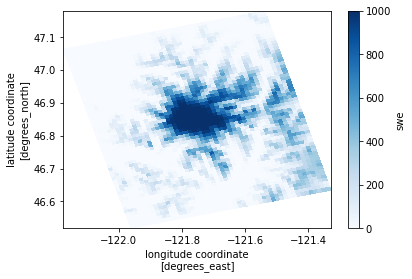

In [13]:
# We can even plot this mean SWE map
rainier_april1.swe.mean('time').plot(x='lon', y='lat', cmap='Blues')

**Make a timeseries of April 1 mean SWE across this whole area:**

Compute the mean SWE across space only, preserving our time dimension.

In [14]:
# mean SWE across the spatial dimsnions only
rainier_april1.swe.mean(['x','y'])

<xarray.DataArray 'swe' (time: 40)>
array([274.0139  , 174.72778 , 328.14166 , 166.95694 , 243.46527 ,
       273.875   , 157.51389 , 140.26111 , 264.44583 , 221.04584 ,
       382.6389  , 129.30417 , 132.36806 , 117.718056, 258.7875  ,
        87.354164, 377.77777 , 229.2264  , 175.85973 , 239.02222 ,
       208.96666 , 176.7625  , 208.7736  , 123.17917 , 100.548615,
        58.818054, 129.69167 , 137.52638 , 257.52084 , 147.22917 ,
        47.2375  , 148.85556 , 251.29445 ,  76.852776,  69.797226,
        41.71389 ,  63.604168, 107.59167 , 119.86806 , 100.85139 ],
      dtype=float32)
Coordinates:
  * time     (time) datetime64[ns] 1980-04-01 1981-04-01 ... 2019-04-01

This lets us then plot a timeseries of April 1 mean SWE for this region around Mt. Rainier over the whole 40 year period.

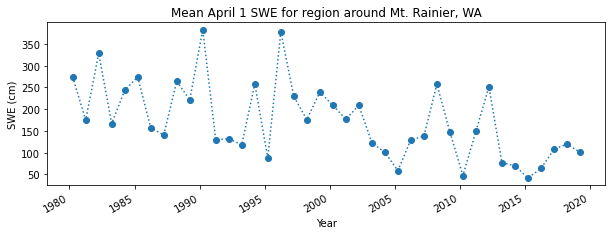

In [15]:
fig, ax = plt.subplots(figsize=(10,3))

rainier_april1.swe.mean(['x','y']).plot(linestyle=':', marker='o', ax=ax)

ax.set_title('Mean April 1 SWE for region around Mt. Rainier, WA');
ax.set_ylabel('SWE (cm)')
ax.set_xlabel('Year');

**With a plot like the one above, we're well on our way to answer "*How has April 1st SWE around Mt. Rainier changed over the past 40 years?*"**

**Similarly, we can get the min, max, median, standard deviation this same way.**

*Over the past 40 years, which parts of the Mt. Rainier area have had the most variable April 1 SWE?*

(as measured by the 40-year standard deviation of April 1 SWE at each grid cell in DayMet)

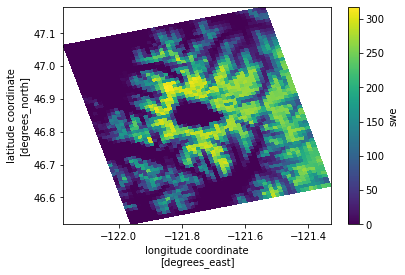

In [16]:
rainier_april1.swe.std(['time']).plot(x='lon',y='lat')

---

## Bonus: plotting Landsat 8 imagery with xarray

[Derived from David Shean's Geospatial Data Analysis course material](https://github.com/UW-GDA/gda_course_2020). Also see more [here](https://rasterio.readthedocs.io/en/latest/), [here](https://scitools.org.uk/cartopy/docs/latest/), and [here](https://xarray.pydata.org/en/stable/examples/visualization_gallery.html).


In [17]:
# Base URL to Landsat 8 Google Cloud archive
base_url = 'https://storage.googleapis.com/gcp-public-data-landsat/LC08/01'

#Define path/row of interest for Mt. Rainier
path = 46
row = 27

#Pre-identified cloud-free Image IDs
img_id1 = 'LC08_L1TP_046027_20181224_20190129_01_T1'
img_id2 = 'LC08_L1TP_046027_20180818_20180829_01_T1'

# Let's use the first one for now
img = img_id1

# Pick which Landsat 8 band we'd like to use
band = 3 # band 3 is the "red" band

# Put together the full url to the image we've specified above
l8_url =  '{0}/{1:03d}/{2:03d}/{3}/{3}_B{4}.TIF'.format(base_url, path, row, img, band)

In [18]:
# Open the geotiff file at this url with xarray
l8_ds = xr.open_rasterio(l8_url)

**What does this dataset look like?**

In [19]:
l8_ds

<xarray.DataArray (band: 1, y: 7881, x: 7771)>
[61243251 values with dtype=uint16]
Coordinates:
  * band     (band) int64 1
  * y        (y) float64 5.373e+06 5.373e+06 5.373e+06 ... 5.137e+06 5.137e+06
  * x        (x) float64 4.728e+05 4.728e+05 4.729e+05 ... 7.059e+05 7.059e+05
Attributes:
    transform:      (30.0, 0.0, 472785.0, 0.0, -30.0, 5373315.0)
    crs:            +init=epsg:32610
    res:            (30.0, 30.0)
    is_tiled:       1
    nodatavals:     (nan,)
    scales:         (1.0,)
    offsets:        (0.0,)
    AREA_OR_POINT:  Point

It has a coordinate reference system (CRS) we can use to reproject the Landsate image into our Daymet coordinate system

In [20]:
landsat8_crs = l8_ds.crs

In [21]:
# Specify the region we want to look at with Landsat (lon_min, lat_min, lon_max, lat_max)
# and the coordinate system we are providing the bounding box coordinates in (epsg:4326)
# finally, reproject our bounding box polygon into this new coordinate system
bounding_box = gpd.GeoSeries(geometry.box(-122.0, 46.6, -121.5, 47.1), crs='epsg:4326').to_crs(landsat8_crs)

# Select this region from our DayMet Dataset
landsat8_rainier = l8_ds.sel(x = slice(bounding_box.bounds.minx[0], bounding_box.bounds.maxx[0]),
                             y = slice(bounding_box.bounds.maxy[0], bounding_box.bounds.miny[0]))

/opt/conda/envs/whw/lib/python3.6/site-packages/pyproj/crs/crs.py:280: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  projstring = _prepare_from_string(projparams)


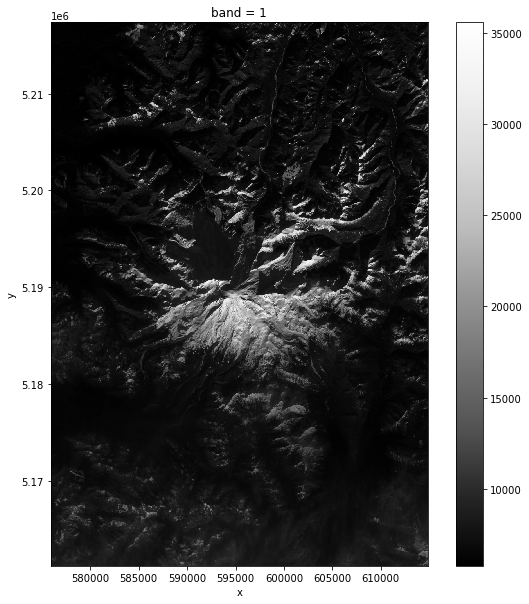

In [23]:
fig, ax = plt.subplots(figsize=(10,10))

landsat8_rainier.plot(ax=ax, cmap='Greys_r')

ax.set_aspect(1)